In [1]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from tqdm import tqdm
import pandas as pd

$$
\newcommand{\GP}{\mathcal{GP}}
$$

# Problem: Toy non-linear regression

We are going to use the toy dataset from 
$$
\GP
$$

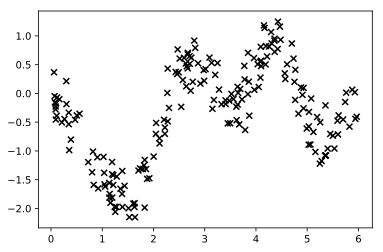

In [2]:
X_n = pd.read_csv('./data/train_inputs', header=None, sep='\s+').values
Y = pd.read_csv('./data/train_outputs', header=None, sep='\s+').values

plt.scatter(X_n, Y, marker='x', color='k')

In [29]:
def rbf(X, sigma_f, length_scale):
    
    num_points = X.shape[0]
    
    cov = np.dot(X, X.T)
    diag = np.diag(cov)
    
    # (x_n - x_m)' (x_n - x_m) = x_n'x_n + x_m'x_m - 2x_n'x_m
    cov_ = diag.reshape((num_points, 1)) + diag.reshape((1, num_points)) - 2 * cov
    
    return (sigma_f ** 2.) * np.exp(-1. / (2 * length_scale ** 2.) * cov_)


def woodbury(A_diag, B, C, D):
    """
    Calculates the inverse of a corrected diagonal matrix in O(N x M^2) time.
    
    A_diag - Vector representation of an N x N diagonal matrix 
    B - N x M matrix
    C - M x N matrix
    D - M x M invertible matrix
    
    (A + B(D_inv)C)_inv = A_inv - A_inv B(D + CA_inv B)_inv CA_inv
    
    E = (D + CA_inv B)_inv
    
    https://en.wikipedia.org/wiki/Woodbury_matrix_identity
    """
    # Ensure A is a vector
    if len(A_diag.shape) != 1: 
        raise Exception("A has to be a vector!")
    
    n = A_diag.shape[0]
    m = D.shape[0]
    
    # Ensure conformity of matrices
    if B.shape != (n, m) or C.shape != (m, n) or D.shape != (m, m):
        raise Exception("A {}, B {}, C {} and D {} have to be conformal!".format(
            A_diag.shape*2, B.shape, C.shape, D.shape))
    
    A_diag_inv = 1. / A_diag

    E = np.linalg.inv(D + np.dot(C * A_diag_inv.reshape((1, -1)), B))
    
    inv = -np.dot(np.dot(A_diag_inv.reshape((-1, 1)) * B, E), C * A_diag_inv.reshape((1, -1)))
    
    inv[np.diag_indices_from(inv)] += A_diag_inv.squeeze()
    
    return inv

def fast_matrix_det(A_diag, B, C, D):
    """
    Calculates the determinant of a corrected diagonal matrix in O(N x M^2) time.
    
    A_diag - Vector representation of an N x N diagonal matrix 
    B - N x M matrix
    C - M x N matrix
    D - M x M invertible matrix
    
    | A + B D_inv C | = | D + C A_inv B | x | D_inv | x | A |
    
    https://en.wikipedia.org/wiki/Matrix_determinant_lemma#Generalization
    """
    # Ensure A is a vector
    if len(A_diag.shape) != 1: 
        raise Exception("A has to be a vector!")
    
    n = A_diag.shape[0]
    m = D.shape[0]
    
    # Ensure conformity of matrices
    if B.shape != (n, m) or C.shape != (m, n) or D.shape != (m, m):
        raise Exception("A {}, B {}, C {} and D {} have to be conformal!".format(
            A_diag.shape*2, B.shape, C.shape, D.shape))
    
    
    A_diag_inv = 1. / A_diag
    
    return np.linalg.det(D + np.dot(C * A_diag_inv.reshape((1, -1)), B)) * \
            np.linalg.det( np.linalg.inv(D) ) * np.prod(A_diag)


def fast_quadratic_form(A_diag, B, C, D, ys):
    """
    Calculates the quadratic form 
    
        y' (A + B(D_inv)C)_inv y 
    
    in O(N x M^2) time.
    
    A_diag - Vector representation of an N x N diagonal matrix 
    B - N x M matrix
    C - M x N matrix
    D - M x M invertible matrix
    
        (A + B(D_inv)C)_inv = A_inv - A_inv B(D + CA_inv B)_inv CA_inv
    
        E = (D + CA_inv B)_inv
    
    https://en.wikipedia.org/wiki/Woodbury_matrix_identity
    """
    # Ensure A is a vector
    if len(A_diag.shape) != 1: 
        raise Exception("A has to be a vector!")
        
    # Ensure ys is a vector
    if len(ys.shape) != 1: 
        raise Exception("ys has to be a vector!")
    
    n = A_diag.shape[0]
    m = D.shape[0]
    
    # Ensure conformity of ys with the matrices
    if len(ys) != n:
        raise Exception("ys (length {}) has to match the dimensions of the matrix ({}, {})!".format(
            len(ys), n, n))
    
    # Ensure conformity of matrices
    if B.shape != (n, m) or C.shape != (m, n) or D.shape != (m, m):
        raise Exception("A {}, B {}, C {} and D {} have to be conformal!".format(
            A_diag.shape*2, B.shape, C.shape, D.shape))
    
    A_diag_inv = 1. / A_diag
    
    A_inv_ys = A_diag_inv * ys
    
    ys_A_inv_ys = np.dot(ys, A_inv_ys)

    E = np.linalg.inv(D + np.dot(C * A_diag_inv.reshape((1, -1)), B))

    ys_A_inv_B = np.dot(A_inv_ys.reshape((1, -1)), B)
    C_A_inv_ys = np.dot(C, A_inv_ys.reshape((-1, 1)))
    
    return ys_A_inv_ys - np.dot(np.dot(ys_A_inv_B, E), C_A_inv_ys)
    


def free_energy(X_n, X_m, Y, sigma_noise, sigma_f, length_scale, verbose=False):
    n = len(X_n)
    
    K = rbf(np.concatenate((X_n, X_m), axis=0), sigma_f, length_scale)
    
    K_nn = K[:n, :n]
    
    K_mm = K[n:, n:]
    K_mm_inv = np.linalg.inv(K_mm)
    #K_mm_inv = K_mm_inv + 1e-6 * np.eye(len(K_mm))
    
    K_nm = K[:n, n:]
    
    noise_cov_diag = (sigma_noise ** 2.) * np.ones(n)
    noise_cov = (sigma_noise ** 2.) * np.eye(n)
    
    gp_cov = np.dot(np.dot(K_nm, K_mm_inv), K_nm.T)
    det_gp_cov_slow = np.linalg.det(noise_cov + gp_cov)
    det_gp_cov = fast_matrix_det(noise_cov_diag, K_nm, K_nm.T, K_mm)
    #gp_cov_inv = woodbury(noise_cov_diag, K_nm, K_nm.T, K_mm)
    gp_QF = fast_quadratic_form(noise_cov_diag, K_nm, K_nm.T, K_mm, Y)
    
    log_prob_gaussian = -n / 2. * np.log(2 * np.pi) \
                        -0.5 * np.log(det_gp_cov) \
                        -0.5 * gp_QF
    
    regularising_term = 1. / (2 * sigma_noise ** 2.) * (np.trace(K_nn) - np.trace(gp_cov))
    
    if verbose:
        print("\n==================")
        #print(K_mm)
        print()
        print(np.linalg.det(noise_cov))
        print(np.linalg.det(K_mm_inv), det_gp_cov)
        print(det_gp_cov_slow)
        print(gp_QF)
        print(regularising_term)
        print("\n==================")
    return log_prob_gaussian - regularising_term

In [116]:
def fit(X_n, X_m, Y, log_sigma_noise=1., log_sigma_f=0., log_length_scale=0., learn_rate=1e-10, num_iter=10000, verbose=True):
    
    log_every = 100
    
    F_lambda = lambda X_m_, log_sigma_noise_, log_sigma_f_, log_length_scale_: \
                   free_energy(X_n, X_m_, Y, np.exp(log_sigma_noise_), np.exp(log_sigma_f_), np.exp(log_length_scale_))
    
    dF_dX_m = grad(F_lambda, 0)
    dF_dlog_sigma_noise = grad(F_lambda, 1)
    dF_dlog_sigma_f = grad(F_lambda, 2)
    dF_dlog_length_scale = grad(F_lambda, 3)

    for i in range(num_iter):
        X_m = X_m + learn_rate * dF_dX_m(X_m, log_sigma_noise, log_sigma_f, log_length_scale)
        log_sigma_noise = log_sigma_noise + learn_rate * dF_dlog_sigma_noise(X_m, log_sigma_noise, log_sigma_f, log_length_scale)
        log_sigma_f = log_sigma_f + learn_rate * dF_dlog_sigma_f(X_m, log_sigma_noise, log_sigma_f, log_length_scale)
        log_length_scale = log_length_scale + learn_rate * dF_dlog_length_scale(X_m, log_sigma_noise, log_sigma_f, log_length_scale)
        
        #print(log_sigma_noise, log_sigma_f, log_length_scale)
        yield (X_m, log_sigma_noise, log_sigma_f, log_length_scale)

In [117]:
def get_predictive_gp(X_m, Y, sigma_noise, sigma_f, length_scale):
    """
    """
    n = len(X_n)
    
    K = rbf(np.concatenate((X_n, X_m), axis=0), sigma_f, length_scale)
    
    K_nn = K[:n, :n]
    
    K_mm = K[n:, n:]
    K_mm_inv = np.linalg.inv(K_mm)
    #K_mm_inv = K_mm_inv + 1e-6 * np.eye(len(K_mm))
    
    K_nm = K[:n, n:]
    
    Sigma = np.linalg.inv(K_mm + sigma_noise ** -2. * np.dot(K_nm.T, K_nm))
    mu = sigma_noise ** -2. * np.dot(np.dot(Sigma, K_nm.T), Y.reshape(-1, 1))
    
    def mu_fn(x_pred):
        
        x_pred = x_pred.reshape((1, 1))
        K_ = rbf(np.concatenate((x_pred, X_m), axis=0), sigma_f, length_scale)
#         print(np.concatenate((x_pred, X_m), axis=0).shape)
#         print(X_m)
        K_xm = K_[:1, 1:]
        return np.dot(K_xm, mu)
    
    def cov_fn(x_pred):
        
        x_pred = x_pred.reshape((1, 1))
        K_ = rbf(np.concatenate((x_pred, X_m), axis=0), sigma_f, length_scale)
        K_xx = K_[:1, :1]
        K_xm = K_[:1, 1:]
        
        return K_xx - np.dot(np.dot(K_xm, K_mm_inv), K_xm.T) \
                + np.dot(np.dot(K_xm, Sigma), K_xm.T)
    
    return mu_fn, cov_fn

(20, 1)
(200, 1)
[[-393.30433113]]


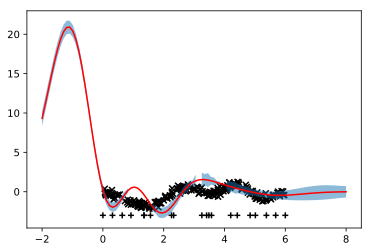

[[-393.78593717]]


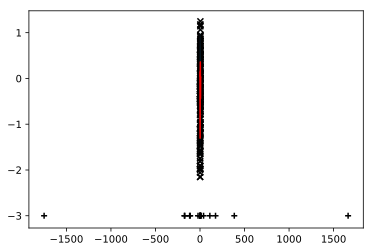

[[-393.78558817]]


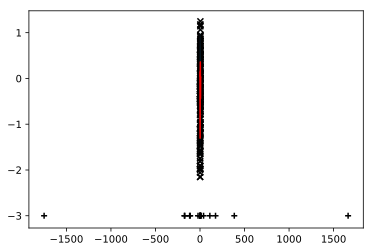

KeyboardInterrupt: 

In [119]:
X_m_init = np.linspace(0., 6., 20).reshape((-1, 1))
Y = Y.squeeze()
print(X_m_init.shape)
print(X_n.shape)

xs = np.linspace(-2., 8., 100)

for i, (X_m, log_sigma_noise, log_sigma_f, log_length_scale) in enumerate(fit(X_n, X_m_init, Y)):
    
    if i % 100 == 0:
        print(free_energy(X_n, X_m, Y, np.exp(log_sigma_noise), np.exp(log_sigma_f), np.exp(log_length_scale)))
        
        mu_fn, cov_fn = get_predictive_gp(X_m, Y, np.exp(log_sigma_noise), np.exp(log_sigma_f), np.exp(log_length_scale))
        
        mus = np.array([mu_fn(x) for x in xs])
        stds = np.array([np.sqrt(cov_fn(x)) for x in xs])

        plt.scatter(X_n, Y, marker='x', color='k')
        
        plt.scatter(X_m, -3 * np.ones_like(X_m), marker='+', color='k')
        
        plt.fill_between(xs, (mus-stds).squeeze(), (mus+stds).squeeze(), alpha=.5)
        
        plt.plot(xs, mus.squeeze(), color='r')
        
        plt.show()
        
        

In [46]:
a = np.eye(3000)
b = np.random.random((3000, 4))
d = np.random.random((4, 4))
c = np.random.random((4, 3000))
d_inv = np.linalg.inv(d)

m = a + np.dot(np.dot(b, d_inv), c)

m_inv = np.linalg.inv(m)
#print(woodbury(np.ones(10), b, c, d))
#print(m_inv)

ys = np.ones(3000)

a_diag = np.ones(3000)

%time print(np.dot(np.dot(ys.reshape(1, -1), np.linalg.inv(m)), ys.reshape(-1, 1)))
%time print(fast_quadratic_form(a_diag, b, c, d, ys))
print("\n")

%time print(np.linalg.det(m))
%time print(fast_matrix_det(a_diag, b, c, d))

print("\n")

print(np.sum(np.abs(np.linalg.inv(m) - woodbury(a_diag, b, c, d))))

KeyboardInterrupt: 